In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 679 kB 7.8 MB/s 


# Import package


In [3]:
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional,dot,SpatialDropout1D, Activation,Conv1D,Dropout,MaxPooling1D,GlobalAveragePooling1D,Flatten,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy, Recall, Precision, AUC
from sklearn.metrics import confusion_matrix,classification_report
# from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns


import warnings
#pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.5.0


# Read Data

In [4]:
train_df = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/DataTitle/PPV2train_news.csv")
train_df.text=train_df.text.astype(str)

val_df = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/DataTitle/PPV2val_news.csv")
val_df.text=val_df.text.astype(str)

test_df = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/DataTitle/PPV2test_news.csv")
test_df.text=test_df.text.astype(str)

train_df.shape , test_df.shape ,val_df.shape

((5128, 2), (1603, 2), (1282, 2))

In [5]:
train_df.label.value_counts().sort_values()

0    1297
1    3831
Name: label, dtype: int64

In [6]:
test_df.label.value_counts().sort_values()

0     403
1    1200
Name: label, dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5128 entries, 0 to 5127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5128 non-null   object
 1   label   5128 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.2+ KB


In [8]:
len(train_df.text),len(train_df.label)

(5128, 5128)

In [9]:
longest_text= 0
for sent in train_df['text']:
  #print(sent)
  if len(sent.split()) > longest_text:
      longest_text = len(sent.split())

print(longest_text)


414


# Siplt Label

In [10]:
x_train=train_df['text']
y_train=train_df['label']

x_val=val_df['text']
y_val=val_df['label']

x_test=test_df['text']
y_test=test_df['label']

# Tokenizer, sequences & padding

In [11]:
MAX_NB_WORDS = 20000
MAX_TEXT_LEN = longest_text

In [12]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=MAX_NB_WORDS) 
x_tokenizer.fit_on_texts(x_train)

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train =   pad_sequences(x_train_seq,  maxlen=MAX_TEXT_LEN, padding='post')
x_val   =   pad_sequences(x_val_seq,    maxlen=MAX_TEXT_LEN, padding='post')

#size of vocabulary ( +1 for padding token)
VOC_SIZE =  len(x_tokenizer.word_index) +1 
print("Size of vocabulary in X = {}".format(VOC_SIZE))

Size of vocabulary in X = 22308


In [13]:
#prepare test data set
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)
x_test   =   pad_sequences(x_test_seq,    maxlen=MAX_TEXT_LEN, padding='post')

# Plot Function

In [14]:
def plot_model_learning(history, title):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
    df[['loss', 'val_loss']].plot(ax=ax[1])
    ax[0].set_title('Model Accuracy', fontsize=12)
    ax[1].set_title('Model Loss', fontsize=12)
    fig.suptitle(f'{title}: Model Metrics', fontsize=18)

In [15]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# Train Model

## Constant

In [16]:
METRICS = [
    tf.keras.metrics.AUC(name='roc-auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(num_classes=1,average='macro',name='f1_score',threshold=0.5 )
      ]

In [17]:
def callbacks(filepath):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  #ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  #rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)
  return es#,ckpt,rlp

In [18]:
# optimizers
adam = tf.keras.optimizers.Adam(lr = 0.001)

In [19]:
Embedding_DIM=300
MAX_EPOCHS=100
BATCH_SIZE=64
val_dict = {"NAME":[],"METRICS":[],"CONFUSION_MATRIX":[]};
test_dict = {"NAME":[],"METRICS":[],"CONFUSION_MATRIX":[]};

In [20]:
x_train[2],y_train[2]

(array([5041, 8482, 2700, 8483, 1160,  374,    1, 2187, 8484,  177,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

## Bidirectional Lstm

In [21]:
def bidirectional_lstm():
    model = Sequential()
    model.add(Input(shape=(MAX_TEXT_LEN,), dtype="int32"))
    model.add(Embedding(VOC_SIZE, Embedding_DIM, trainable=True))
    model.add(Bidirectional(LSTM(32, return_sequences = True, dropout=0.3)))
    model.add(Bidirectional(LSTM(64, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(LSTM(128, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(LSTM(64, return_sequences = False, dropout=0.3 )))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=METRICS)
    
    return model

model = bidirectional_lstm()
model.summary()

history = model.fit(x_train,y_train,
                    epochs=MAX_EPOCHS,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks('bidirectional_lstm.png')],
                    batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 414, 300)          6692400   
_________________________________________________________________
bidirectional (Bidirectional (None, 414, 64)           85248     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 414, 128)          66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 414, 256)          263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 7,271,345
Trainable params: 7,271,345
Non-trainable params: 0
______________________________________________

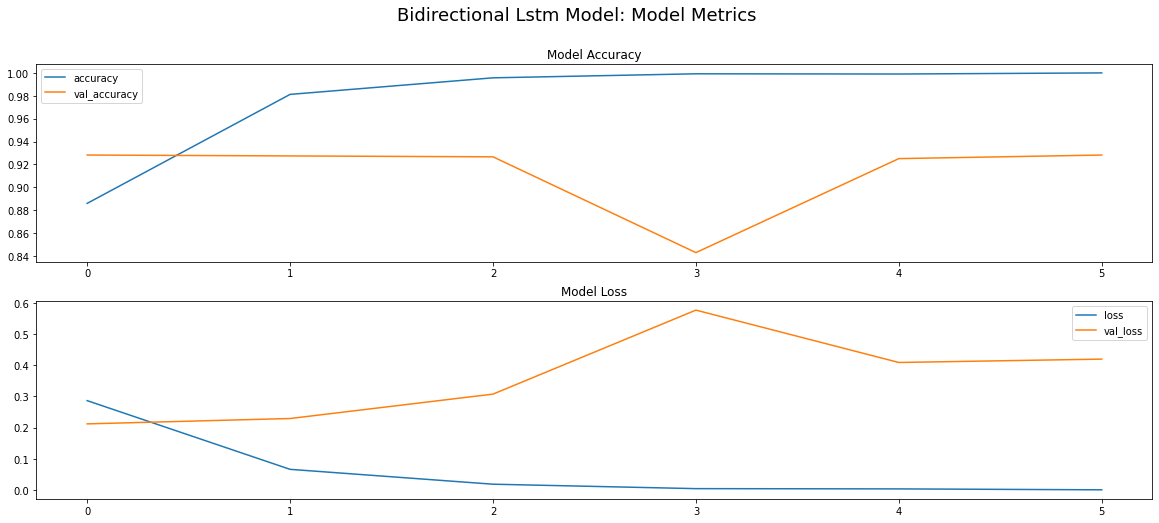

In [22]:
#Plot Model
plot_model_learning(history,'Bidirectional Lstm Model')

### Model Evaluation

41/41 [==============================] - 2s 57ms/step - loss: 0.4193 - roc-auc: 0.9062 - accuracy: 0.9282 - precision: 0.9346 - recall: 0.9732 - f1_score: 0.9535
Accuracy: 92.82%

Classification report
               precision    recall  f1-score   support

           0       0.90      0.79      0.84       313
           1       0.93      0.97      0.95       969

    accuracy                           0.93      1282
   macro avg       0.92      0.88      0.90      1282
weighted avg       0.93      0.93      0.93      1282

Confusion matrix : 247 66 26 943
{'NAME': ['bid_lstm'], 'METRICS': [[0.41933485865592957, 0.9062288999557495, 0.9282371401786804, 0.9345887303352356, 0.9731681942939758, 0.9534884095191956]], 'CONFUSION_MATRIX': [[247, 66, 26, 943]]}


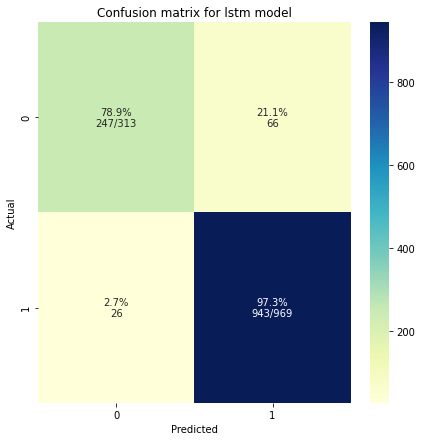

In [23]:
# Evaluate Model
scores = model.evaluate(x_val, y_val)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_val)

print("\nClassification report\n",classification_report(y_val, y_pred))

#Confusion matrix
tn ,fb ,fn , tp= confusion_matrix(y_val, y_pred).ravel()
print("Confusion matrix :",tn ,fb ,fn , tp)

#plot Confusion matrix
plot_cm(y_val, y_pred, 'Confusion matrix for lstm model', figsize=(7,7))

val_dict["NAME"].append("bid_lstm")
val_dict["METRICS"].append(scores)
val_dict["CONFUSION_MATRIX"].append([tn ,fb ,fn , tp])
print(val_dict)

### Evaluate Model on Test DataSet`

51/51 [==============================] - 3s 55ms/step - loss: 0.4222 - roc-auc: 0.9053 - accuracy: 0.9270 - precision: 0.9287 - recall: 0.9775 - f1_score: 0.9525
Accuracy: 92.70%

Classification report
               precision    recall  f1-score   support

           0       0.92      0.78      0.84       403
           1       0.93      0.98      0.95      1200

    accuracy                           0.93      1603
   macro avg       0.92      0.88      0.90      1603
weighted avg       0.93      0.93      0.92      1603

Confusion matrix: 313 90 27 1173


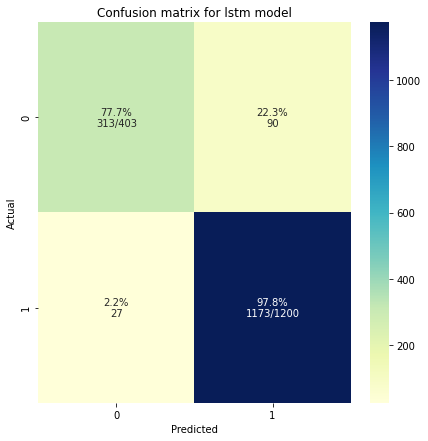

In [24]:
# Evaluate Model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_test)
print("\nClassification report\n",classification_report(y_test, y_pred))

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion matrix:", tn, fp, fn, tp)

#plot Confusion matrix
plot_cm(y_test, y_pred, 'Confusion matrix for lstm model', figsize=(7,7))

test_dict["NAME"].append("bid_lstm")
test_dict["METRICS"].append(scores)
test_dict["CONFUSION_MATRIX"].append([tn, fp, fn, tp])

### Samples

In [25]:
count=0
title_example = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/Data/title_example.csv")
title_example.shape

for title in title_example.text:
  title_seq =  x_tokenizer.texts_to_sequences([title])
  title_pad   =   pad_sequences(title_seq,maxlen=MAX_TEXT_LEN, padding='post')
  y_label  =   model.predict_classes(title_pad)
  if y_label==1 :
    count=count+1
  # y_pred= np.where(y_label > .5, 1, 0)
  # print(title,y_label)

print("Real : "+str(count))


Real : 19


## Deep Bidirectional GRU

In [26]:
def deep_bidirectional_gru():
    model = Sequential()
    model.add(Input(shape=(MAX_TEXT_LEN,), dtype="int32"))
    model.add(Embedding(VOC_SIZE, Embedding_DIM, trainable=True))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(GRU(32, return_sequences = True, dropout=0.3)))
    model.add(Bidirectional(GRU(64, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(GRU(128, return_sequences = True , dropout=0.3)))
    model.add(Bidirectional(GRU(64, return_sequences = False, dropout=0.3 )))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=METRICS)
    
    return model

model = deep_bidirectional_gru()
model.summary()

history = model.fit(x_train,y_train,
                    epochs=MAX_EPOCHS,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks('deep_bidirectional_gru.png')],
                    batch_size=BATCH_SIZE)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 414, 300)          6692400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 414, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 414, 64)           64128     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 414, 128)          49920     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 414, 256)          198144    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

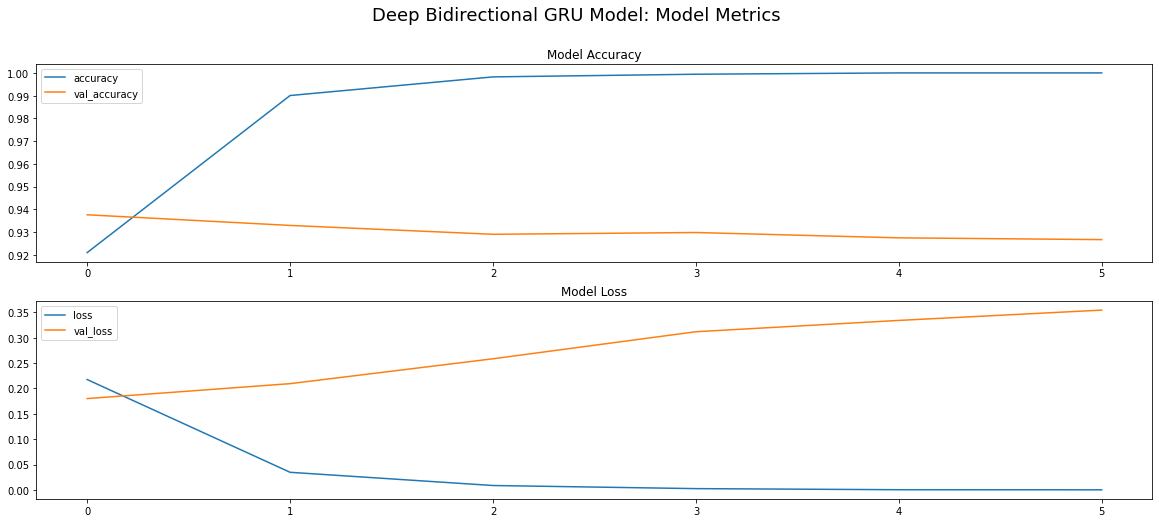

In [27]:
plot_model_learning(history, 'Deep Bidirectional GRU Model')

### Model Evaluation

41/41 [==============================] - 2s 56ms/step - loss: 0.3542 - roc-auc: 0.9379 - accuracy: 0.9267 - precision: 0.9460 - recall: 0.9577 - f1_score: 0.9518
Accuracy: 92.67%

Classification report
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       313
           1       0.95      0.96      0.95       969

    accuracy                           0.93      1282
   macro avg       0.90      0.89      0.90      1282
weighted avg       0.93      0.93      0.93      1282

Confusion matrix : 260 53 41 928
{'NAME': ['bid_lstm', 'deep_bid_gru'], 'METRICS': [[0.41933485865592957, 0.9062288999557495, 0.9282371401786804, 0.9345887303352356, 0.9731681942939758, 0.9534884095191956], [0.35423949360847473, 0.9378941655158997, 0.9266770482063293, 0.9459735155105591, 0.9576883316040039, 0.9517948627471924]], 'CONFUSION_MATRIX': [[247, 66, 26, 943], [260, 53, 41, 928]]}


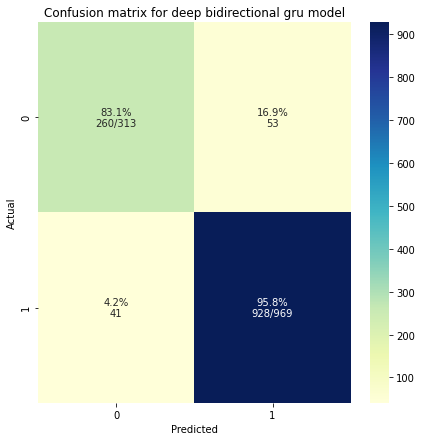

In [28]:
# Evaluate Model
scores = model.evaluate(x_val, y_val)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_val)
print("\nClassification report\n",classification_report(y_val, y_pred))

#Confusion matrix
tn ,fb ,fn , tp= confusion_matrix(y_val, y_pred).ravel()
print("Confusion matrix :",tn ,fb ,fn , tp)

#plot Confusion matrix
plot_cm(y_val, y_pred, 'Confusion matrix for deep bidirectional gru model', figsize=(7,7))

val_dict["NAME"].append("deep_bid_gru")
val_dict["METRICS"].append(scores)
val_dict["CONFUSION_MATRIX"].append([tn ,fb ,fn , tp])
print(val_dict)

### Evaluate Model on Test DataSet




51/51 [==============================] - 3s 51ms/step - loss: 0.3422 - roc-auc: 0.9331 - accuracy: 0.9333 - precision: 0.9461 - recall: 0.9658 - f1_score: 0.9559
Accuracy: 93.33%

Classification report
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       403
           1       0.95      0.97      0.96      1200

    accuracy                           0.93      1603
   macro avg       0.92      0.90      0.91      1603
weighted avg       0.93      0.93      0.93      1603

Confusion matrix: 337 66 41 1159


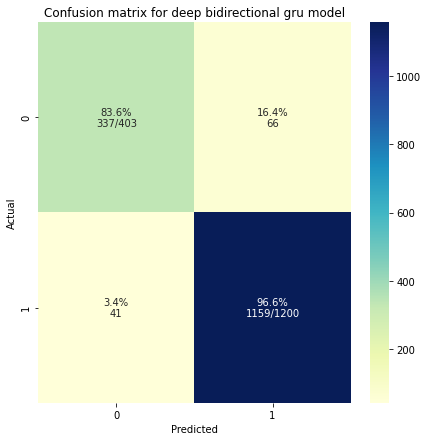

In [29]:
# Evaluate Model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_test)
print("\nClassification report\n",classification_report(y_test, y_pred))

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion matrix:", tn, fp, fn, tp)

#plot Confusion matrix
plot_cm(y_test, y_pred, 'Confusion matrix for deep bidirectional gru model', figsize=(7,7))

test_dict["NAME"].append("deep_bid_gru")
test_dict["METRICS"].append(scores)
test_dict["CONFUSION_MATRIX"].append([tn, fp, fn, tp])

### Samples

In [30]:
count=0
title_example = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/Data/title_example.csv")
title_example.shape

for title in title_example.text:
  title_seq =  x_tokenizer.texts_to_sequences([title])
  title_pad   =   pad_sequences(title_seq,maxlen=MAX_TEXT_LEN, padding='post')
  y_label  =   model.predict_classes(title_pad)
  if y_label==1 :
    count=count+1
  # y_pred= np.where(y_label > .5, 1, 0)
  # print(title,y_label)

print("Real : "+str(count))

Real : 14


## fastText

In [31]:
from tqdm.auto import tqdm
from keras.initializers import Constant

In [32]:
embedding_dim=300
seq_length = longest_text

In [33]:
from gensim.models.keyedvectors import KeyedVectors

def prepare_embedding_index(embedding_name):
    embeddings_index = {}
    if embedding_name == 'Glove':
        f = open('/content/drive/MyDrive/Arabic_FakeNews/Model/Pretrain_Model/GloVe/vocab.txt')
        #embedding_dim = 200
    if embedding_name == 'fastText':
        f = open('/content/drive/MyDrive/Arabic_FakeNews/Model/Pretrain_Model/fastText/cc.ar.300.vec')
        #embedding_dim = 300
    #elif embedding_name == 'AraVec':
        #f = gensim.models.Word2Vec.load('/content/full_grams_cbow_300_twitter.mdl')
        #embedding_dim = 300
        
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    return embeddings_index, embedding_dim


def prepare_embedding_matrix(embeddings_index, embedding_dim, VOC_SIZE, tokenizer):
    count_known = 0
    count_unknown = 0
        
    embedding_matrix = np.zeros((VOC_SIZE, embedding_dim))

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= VOC_SIZE:
            continue
        embedding_vector = None
        try:
            embedding_vector = embeddings_index[word]
        except:
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            count_known += 1
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
            count_unknown += 1

    print(f'{count_known} known vectors\n{count_unknown} random vectors') 
    return embedding_matrix


21758 known vectors
549 random vectors
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 414, 300)          6692400   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 414, 64)           85248     
_________________________________________________________________
dropout (Dropout)            (None, 414, 64)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 414, 128)          66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 414, 128)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 414, 256)          263168    
_________________________________________________________________
dropout_2 (Dro

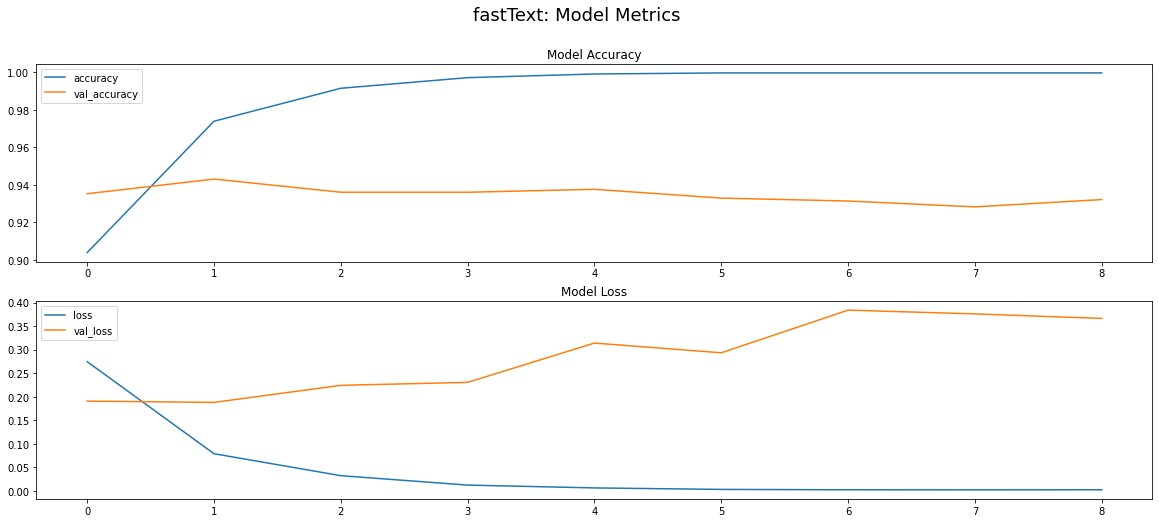

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model_fastText.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

embedding_matrix = prepare_embedding_matrix(
    *prepare_embedding_index('fastText'), VOC_SIZE=VOC_SIZE, tokenizer=x_tokenizer)

model = Sequential()
model.add(Embedding(VOC_SIZE, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_TEXT_LEN, trainable=True))

model.add(Bidirectional(LSTM(32,dropout=0.3,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128,dropout=0.3,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,dropout=0.3)))

model.add(Dense(1, activation='sigmoid'))  

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

model.summary()
#plot_model(model, show_shapes=True)

history = model.fit(x_train,y_train, epochs=MAX_EPOCHS, validation_data=(x_val, y_val), callbacks=[es, ckpt, rlp],batch_size=BATCH_SIZE)

plot_model_learning(history, 'fastText')

### Model Evaluation

41/41 [==============================] - 2s 58ms/step - loss: 0.3663 - roc-auc: 0.9248 - accuracy: 0.9321 - precision: 0.9419 - recall: 0.9701 - f1_score: 0.9558
Accuracy: 93.21%

Classification report
               precision    recall  f1-score   support

           0       0.90      0.81      0.85       313
           1       0.94      0.97      0.96       969

    accuracy                           0.93      1282
   macro avg       0.92      0.89      0.91      1282
weighted avg       0.93      0.93      0.93      1282

Confusion matrix : 255 58 29 940
{'NAME': ['bid_lstm', 'deep_bid_gru', 'FastText BILSTM Model'], 'METRICS': [[0.41933485865592957, 0.9062288999557495, 0.9282371401786804, 0.9345887303352356, 0.9731681942939758, 0.9534884095191956], [0.35423949360847473, 0.9378941655158997, 0.9266770482063293, 0.9459735155105591, 0.9576883316040039, 0.9517948627471924], [0.36625272035598755, 0.9248096346855164, 0.9321373105049133, 0.9418837428092957, 0.9700722098350525, 0.95577013492

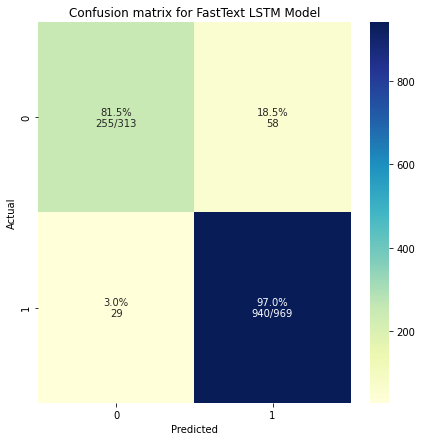

In [35]:
# Evaluate Model
scores = model.evaluate(x_val, y_val)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred=model.predict_classes(x_val)
print("\nClassification report\n",classification_report(y_val, y_pred))

#Confusion matrix
tn ,fb ,fn , tp= confusion_matrix(y_val, y_pred).ravel()
print("Confusion matrix :",tn ,fb ,fn , tp)

#plot Confusion matrix
plot_cm(y_val, y_pred, 'Confusion matrix for FastText LSTM Model', figsize=(7,7))

val_dict["NAME"].append("FastText BILSTM Model")
val_dict["METRICS"].append(scores)
val_dict["CONFUSION_MATRIX"].append([tn ,fb ,fn , tp])
print(val_dict)

### Evaluate Model on Test DataSet

51/51 [==============================] - 3s 56ms/step - loss: 0.3380 - roc-auc: 0.9345 - accuracy: 0.9420 - precision: 0.9417 - recall: 0.9833 - f1_score: 0.9621
Accuracy: 94.20%

Classification report
               precision    recall  f1-score   support

           0       0.94      0.82      0.88       403
           1       0.94      0.98      0.96      1200

    accuracy                           0.94      1603
   macro avg       0.94      0.90      0.92      1603
weighted avg       0.94      0.94      0.94      1603

Confusion matrix: 330 73 20 1180


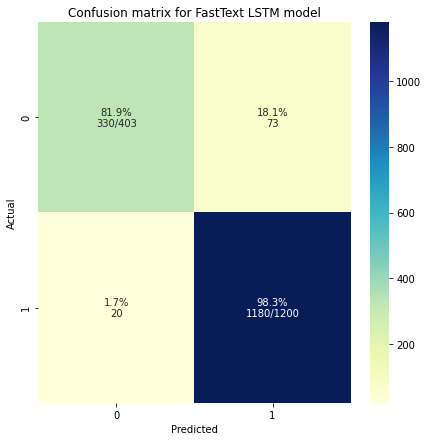

In [36]:
# Evaluate Model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[2]*100))

# predict y
y_pred = model.predict_classes(x_test)
print("\nClassification report\n",classification_report(y_test, y_pred))

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion matrix:", tn, fp, fn, tp)

#plot Confusion matrix
plot_cm(y_test, y_pred, 'Confusion matrix for FastText LSTM model', figsize=(7,7))

test_dict["NAME"].append("FastText BILSTM model")
test_dict["METRICS"].append(scores)
test_dict["CONFUSION_MATRIX"].append([tn, fp, fn, tp])

### Samples

In [37]:
count=0
title_example = pd.read_csv("drive/My Drive/Arabic_FakeNews/Model/Balance/Data/title_example.csv")
title_example.shape

for title in title_example.text:
  title_seq =  x_tokenizer.texts_to_sequences([title])
  title_pad   =   pad_sequences(title_seq,maxlen=MAX_TEXT_LEN, padding='post')
  y_label  =   model.predict_classes(title_pad)
  if y_label==1 :
    count=count+1
  # y_pred= np.where(y_label > .5, 1, 0)
  # print(title,y_label)

print("Real : "+str(count))

Real : 15


# Result Summery

## Validation Result

In [38]:
print('{0:15}{1:105}{2:10}'.format('algorithm', 'metric(loss,roc,accuercy,recall,persion,f1_score)','confusion_matrix'))
print('---------------------------------------------------------------------')
for i in range(3):
  print('{0:15}{1:105}{2:10}'.format(val_dict["NAME"][i], str(val_dict["METRICS"][i]),str(val_dict["CONFUSION_MATRIX"][i])))

algorithm      metric(loss,roc,accuercy,recall,persion,f1_score)                                                        confusion_matrix
---------------------------------------------------------------------
bid_lstm       [0.41933485865592957, 0.9062288999557495, 0.9282371401786804, 0.9345887303352356, 0.9731681942939758, 0.9534884095191956][247, 66, 26, 943]
deep_bid_gru   [0.35423949360847473, 0.9378941655158997, 0.9266770482063293, 0.9459735155105591, 0.9576883316040039, 0.9517948627471924][260, 53, 41, 928]
FastText BILSTM Model[0.36625272035598755, 0.9248096346855164, 0.9321373105049133, 0.9418837428092957, 0.9700722098350525, 0.9557701349258423][255, 58, 29, 940]


## Test Result

In [39]:
print('{0:15}{1:105}{2:10}'.format('algorithm', 'metric(loss,roc,accuercy,recall,persion,f1_score)','confusion_matrix'))
print('---------------------------------------------------------------------')
for i in range(3):
  print('{0:15}{1:105}{2:10}'.format(test_dict["NAME"][i], str(test_dict["METRICS"][i]),str(test_dict["CONFUSION_MATRIX"][i])))



algorithm      metric(loss,roc,accuercy,recall,persion,f1_score)                                                        confusion_matrix
---------------------------------------------------------------------
bid_lstm       [0.42217618227005005, 0.9052677750587463, 0.9270118474960327, 0.9287410974502563, 0.9775000214576721, 0.9524969458580017][313, 90, 27, 1173]
deep_bid_gru   [0.34218114614486694, 0.9330883026123047, 0.9332501292228699, 0.9461224675178528, 0.965833306312561, 0.9558762907981873][337, 66, 41, 1159]
FastText BILSTM model[0.33802878856658936, 0.934455156326294, 0.9419837594032288, 0.9417397975921631, 0.9833333492279053, 0.9620872735977173][330, 73, 20, 1180]
